<a href="https://colab.research.google.com/github/jeeva-18/Deep-learning-projects/blob/main/PUBMED_ABSTRACT_SEGMENTATION/pubmed_abstract_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIMLIT PROJECT - PUBMED 200K RCT

We are going to develope some models that is mentioned on the [paper](https://arxiv.org/abs/1710.06071) and try to improve their performances    

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get dataset

We are going to get dataset from https://github.com/Franck-Dernoncourt/pubmed-rct 


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.47 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# At first we are going to use the pubmed_20k_rct dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir_20percent = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
import os 

os.listdir(data_dir_20percent)

['dev.txt', 'train.txt', 'test.txt']

## Preprocess Data 

our data is in txt file format we have to preprocess them

In [6]:
# get lines from the textfile

def get_lines(filename):
  '''
  This will read your file(.txt) and give you the lines that written on it in the form of list
  '''
  with open(filename,'r') as f:
    return f.readlines()

In [7]:
train_lines = get_lines(os.path.join(data_dir_20percent,'train.txt'))
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
def get_prep_lines(filename):
  text_lines = get_lines(filename)
  lines = []
  for line in text_lines:
    if line.startswith('###'):
      ab_lines = ''
    elif line.isspace():
      ab_lines_split = ab_lines.splitlines()
      # train_dict = dict()
      for line_no,ab_line in enumerate(ab_lines_split):
        train_dict = dict()
        target_text_split = ab_line.split('\t')
        train_dict['line_no'] = line_no
        train_dict['target'] = target_text_split[0]
        train_dict['text'] = target_text_split[1] 
        train_dict['total_lines'] = len(ab_lines_split)-1
        lines.append(train_dict)
    else:
      ab_lines += line
  return lines

In [9]:
%%time

train_samples = get_prep_lines(data_dir_20percent+'train.txt')
val_samples = get_prep_lines(data_dir_20percent+'dev.txt')
test_samples = get_prep_lines(data_dir_20percent+'test.txt') 
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 308 ms, sys: 75.9 ms, total: 384 ms
Wall time: 386 ms


In [10]:
train_samples[:12]

[{'line_no': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_no': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_no': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_no': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_no': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df

,line_no,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
...,...,...,...,...
180035,7,RESULTS,For the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"For PAV , a significantly greater percentage o...",11
180037,9,RESULTS,Both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11


<Axes: >

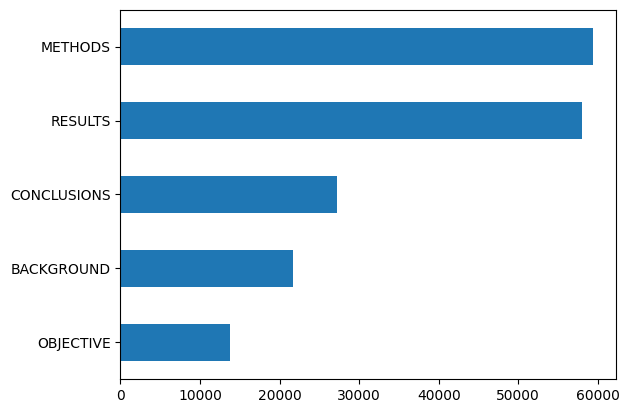

In [13]:
train_df.target.value_counts(ascending=True).plot(kind='barh')

 It looks like the methods and results are showing majority.
 Conclusion has lower values than others 

<Axes: title={'center': 'Total_lines'}, ylabel='Frequency'>

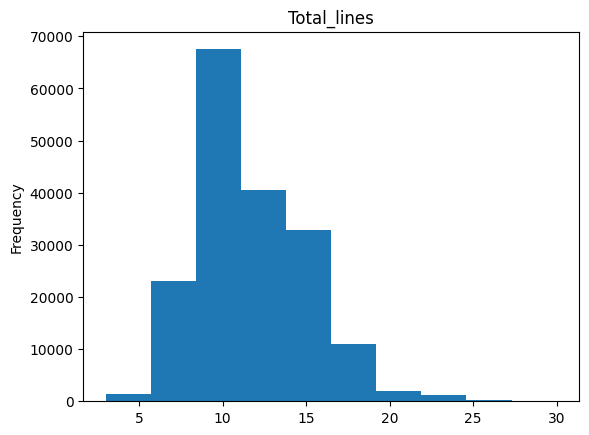

In [14]:
plt.title('Total_lines')
train_df.total_lines.plot(kind='hist')

In [15]:
train_df.total_lines.mean()

11.789135747611642

The most of the abstracts have 10 to 11 lines 

Text(0, 0.5, 'words_count')

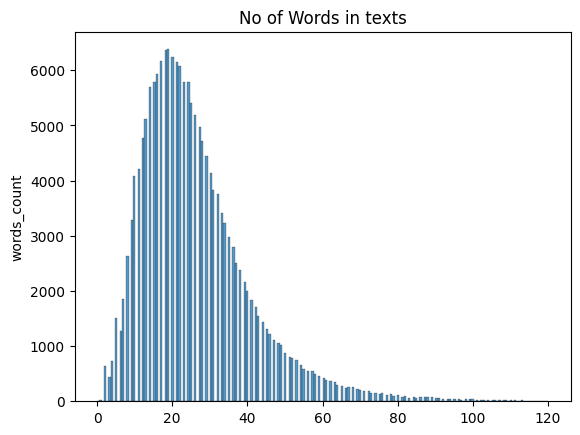

In [16]:
plt.title('No of Words in texts')
sns.histplot([len(i.split()) for i in train_df.text],binrange=(0,120))
plt.ylabel('words_count')

In [17]:
# lets see the avearge lenght of the texts

print('Average words in text: ',round(sum([len(i.split()) for i in train_df.text])/len(train_df.text)))

Average words in text:  26


In [18]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [19]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [20]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(sparse_output=False)

train_target_onehot = onehotencoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_target_onehot = onehotencoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_target_onehot = onehotencoder.transform(test_df['target'].to_numpy().reshape(-1,1)) 

In [21]:
train_target_onehot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder  = LabelEncoder()

train_labels_enc = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_enc = label_encoder.transform(val_df['target'].to_numpy())
test_labels_enc = label_encoder.transform(test_df['target'].to_numpy()) 

In [23]:
train_labels_enc

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_ 

## Model_0(Naive_Bayes_classifier)

well it is our baseline model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

train_sent_idf = vectorizer.fit_transform(train_sentences)
val_sent_idf  = vectorizer.transform(val_sentences)
test_sent_idf = vectorizer.transform(test_sentences) 

In [26]:
from sklearn.naive_bayes import MultinomialNB

model_0 = MultinomialNB(alpha=0.75)

model_0.fit(train_sent_idf,train_labels_enc)

MultinomialNB(alpha=0.75)

In [27]:
model_0.score(val_sent_idf,val_labels_enc)

0.7287501654971534

In [28]:
model_0.score(test_sent_idf,test_labels_enc)

0.7240418118466899

In [29]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

def calculate_results(y_true,y_pred):
  acc = accuracy_score(y_true,y_pred)
  pres,rec,f1,_= precision_recall_fscore_support(y_true,y_pred,average="weighted") 
  results = {
      'Accuracy': acc,
      'Precision': pres,
      'F1_score':f1,
      'Recall':rec
  }
  return results

In [30]:
pred_0_probs = model_0.predict_proba(val_sent_idf)

In [31]:
val_pred = model_0.predict(val_sent_idf)
val_pred[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [32]:
model_0_results = calculate_results(val_labels_enc,val_pred)
model_0_results

{'Accuracy': 0.7287501654971534,
 'Precision': 0.7233706887108281,
 'F1_score': 0.7100887574597206,
 'Recall': 0.7287501654971534}

## Model_1 (CONV1D)

In [33]:
from tensorflow.keras.layers import TextVectorization
max_features = 68000  # Maximum vocab size.
max_len = 55 

text_vect = TextVectorization(
    max_tokens=max_features,
    pad_to_max_tokens=True,
    output_sequence_length = max_len,
)

In [34]:
text_vect.adapt(train_sentences)

lets check with random sentences

In [35]:
import random

random_sent = random.choice(train_sentences)

print(f'''Text : {random_sent} 
\n text_lenght:{len(random_sent.split())}
\n vector : {text_vect([random_sent])}
''')

Text : Australian New Zealand Clinical Trials Registry : ACTRN@ . 

 text_lenght:9

 vector : [[1561  319 1691   47  233 1150 1776    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]



In [36]:
vocab_words  = text_vect.get_vocabulary()

print(f'The most common words : {vocab_words[:10]}\n')
print(f"The least common words : {vocab_words[-10:]}")

The most common words : ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

The least common words : ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
text_vect.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [38]:
from tensorflow.keras.layers import Embedding

embed = Embedding(input_dim=len(vocab_words),
                  output_dim=128,
                  mask_zero=False)

In [39]:
random_sent = random.choice(train_sentences)

print(f'''Text : {random_sent} 
\n text_lenght:{len(random_sent.split())}
\n vector : {text_vect([random_sent])}
\n embedding: {embed(text_vect([random_sent]))}
\n embedding_shape: {embed(text_vect([random_sent])).shape}
''')

Text : Using a two-arm randomized controlled trial , this @-month study builds upon the community-based progressive resistance training ( PRT ) programme Lift for Life to evaluate whether ingestion of a whey-protein drink combined with vitamin D supplementation can enhance the effects of PRT on glycaemic control , body composition and cardiometabolic health in older adults with type @ diabetes . 

 text_lenght:60

 vector : [[   59     8  3796    29   106    32    23   178    17 15154  1864     2
   2086  1754   504   155  6884   755  9660    11   195     6   164   180
   2548     4     8 24071  2244   286     7   412   187   464   171  1335
      2    71     4  6884    18  2633    35   239  1311     3  3364    97
      5   350   266     7   248   223     0]]

 embedding: [[[-0.00900127  0.03411437 -0.02146124 ...  0.01646331 -0.03127535
    0.00894219]
  [-0.02979807  0.04256704 -0.02268467 ... -0.02188739  0.03957218
    0.0168083 ]
  [-0.04966936 -0.00166859  0.00548428 ... -0.00754

since we are using the tensorflow as our backend so we have to use all of its potential

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_target_onehot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_target_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_target_onehot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
#model_1

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vect(inputs) # vectorize text inputs
token_embeddings = embed(text_vectors) # create embedding
x = layers.Conv1D(128, kernel_size=5, activation="relu")(token_embeddings)
# x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
# x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [84]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 51, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 5)                 645 

In [85]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [86]:
cpkt_path = '/check_point'

model_cpkt = tf.keras.callbacks.ModelCheckpoint(cpkt_path,save_best_only=True,save_weights_only=True) 

In [87]:
dir_name = 'pubmed_models'

history_1 = model_1.fit(train_dataset,epochs=3,
                        steps_per_epoch = len(train_dataset),
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)),
                        callbacks=[create_tensorboard_callback(dir_name,'model_0(conv1D)'),model_cpkt])

Saving TensorBoard log files to: pubmed_models/model_0(conv1D)/20230523-085035
Epoch 1/3
5627/5627 [==============================] - 97s 17ms/step - loss: 0.6152 - accuracy: 0.7749 - val_loss: 0.5328 - val_accuracy: 0.8039
Epoch 2/3
5627/5627 [==============================] - 35s 6ms/step - loss: 0.4408 - accuracy: 0.8449 - val_loss: 0.5317 - val_accuracy: 0.8039
Epoch 3/3
5627/5627 [==============================] - 37s 7ms/step - loss: 0.3480 - accuracy: 0.8809 - val_loss: 0.5785 - val_accuracy: 0.7999


In [88]:
model_1.load_weights(cpkt_path)

In [89]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5316 - accuracy: 0.8122


[0.5316047072410583, 0.8121607303619385]

In [90]:
pred_1_probs = model_1.predict(val_dataset)
pred_1 = pred_1_probs.argmax(axis=1)

945/945 [==============================] - 2s 2ms/step


In [91]:
model_1_results = calculate_results(pred_1,val_labels_enc)
model_1_results

{'Accuracy': 0.8121607308354296,
 'Precision': 0.8218842792726962,
 'F1_score': 0.8150497323834135,
 'Recall': 0.8121607308354296}

## Model_2 (pretrained model)

In [66]:
import tensorflow_hub as hub

use_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                             trainable=False,
                             input_shape=[]
                             ,dtype=tf.string)

In [67]:
random_sent = random.choice(train_sentences)

print(f'''Text : {random_sent} 
\n text_lenght:{len(random_sent.split())}
\n embedding: {use_encoder([random_sent])}
\n embedding_shape: {use_encoder([random_sent]).shape}
''')

Text : Before widespread implementation , however , the use of these adjuncts requires proper scrutiny of their effects on psychological practice . 

 text_lenght:21

 embedding: [[ 0.03092964  0.05102318  0.05192336 -0.06629844  0.02967609 -0.038968
   0.06649394  0.04895967 -0.07745887  0.0089832  -0.01754853  0.03972314
   0.03235834  0.05213372  0.00431085 -0.00563433 -0.04696249 -0.03110986
  -0.08878756 -0.0873074  -0.01181083  0.04210256 -0.07362629 -0.02610035
  -0.00266171  0.03711939  0.04815395 -0.06402978 -0.00080401 -0.00872062
  -0.0144858  -0.05380649 -0.00983894  0.01932731 -0.03027769  0.03199298
  -0.00630439 -0.06823976 -0.03604343 -0.03591812 -0.05412351  0.02559732
   0.02326147 -0.03254508  0.0346324   0.04320396  0.04651416  0.06605162
  -0.04921876  0.01783539 -0.02969939  0.01071341  0.03904055 -0.01926976
   0.04001122 -0.0437864   0.04932922  0.02183786  0.06510969  0.03063783
   0.00347195  0.00829979  0.03263506  0.02059123  0.00225843 -0.03114697
   0.0087

In [92]:
inputs = layers.Input(shape=[],dtype=tf.string)
encoder = use_encoder(inputs)
x = layers.Dense(128,activation='relu')(encoder)
outputs = layers.Dense(5,activation='softmax')(x)

model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [93]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [94]:
history_2 = model_2.fit(train_dataset,epochs=3,
                        steps_per_epoch = len(train_dataset),
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)),
                        callbacks=[create_tensorboard_callback(dir_name,'model_1(use)'),model_cpkt])

Saving TensorBoard log files to: pubmed_models/model_1(use)/20230523-085423
Epoch 1/3
5627/5627 [==============================] - 73s 13ms/step - loss: 0.7317 - accuracy: 0.7201 - val_loss: 0.6551 - val_accuracy: 0.7523
Epoch 2/3
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6372 - accuracy: 0.7584 - val_loss: 0.6181 - val_accuracy: 0.7663
Epoch 3/3
5627/5627 [==============================] - 71s 13ms/step - loss: 0.6024 - accuracy: 0.7719 - val_loss: 0.6046 - val_accuracy: 0.7729


In [95]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6089 - accuracy: 0.7675


[0.6089118719100952, 0.7675427198410034]

In [96]:
pred_2_probs = model_2.predict(val_dataset)
pred_2 = pred_2_probs.argmax(axis=1)

945/945 [==============================] - 12s 12ms/step


In [97]:
model_2_results = calculate_results(val_labels_enc,pred_2)
model_2_results

{'Accuracy': 0.7675426982655899,
 'Precision': 0.7656447147201143,
 'F1_score': 0.7630869620768698,
 'Recall': 0.7675426982655899}

lets create model_1 with character embbedings 

In [45]:
# create function that spilt and add space between the words in sentences 

def split_chars(text):
  return ' '.join(list(text))

In [46]:
split_chars(train_sentences[0])

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [47]:
train_chars = [split_chars(i) for i in train_sentences]
val_chars = [split_chars(i) for i in val_sentences]
test_chars = [split_chars(i) for i in test_sentences]

In [48]:
train_chars[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

create textvectorization for the character level tokenenization

In [49]:
import string 

chars = string.ascii_lowercase+ string.digits + string.punctuation
chars 

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [50]:
char_lens = [len(i) for i in train_sentences]
np.mean(char_lens)

149.3662574983337

In [51]:
np.percentile(char_lens,95) # this value would cover 95% of the lengths

290.0

<Axes: title={'center': 'Characters in Sentences'}, ylabel='Count'>

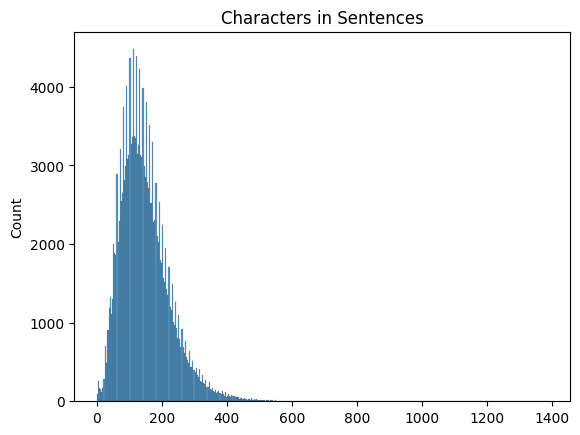

In [52]:
plt.title('Characters in Sentences')
sns.histplot(char_lens)

In [53]:
char_vectorizer = TextVectorization(max_tokens = len(chars)+2,
                                    output_sequence_length = 290)
char_vectorizer.adapt(train_chars)

In [54]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab[:10],len(char_vocab)

(['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's'], 28)

In [55]:
random_sent = random.choice(train_chars)

print(f'''Text : {random_sent} 
\n text_lenght:{len(random_sent.split())}
\n vector : {char_vectorizer([random_sent])}
''')

Text : A   t o t a l   o f   @   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   r e c e i v e   e i t h e r   t h e   C h u a n h u   a n t i - g o u t   m i x t u r e   o r   C o l c h i c i n e   . 

 text_lenght:91

 vector : [[ 5  3  7  3  5 12  7 17 14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10
   7 15 12 19  5  9  9  4 18  6  2 10  3  7  8  2 11  2  4 21  2  2  4  3
  13  2  8  3 13  2 11 13 16  5  6 13 16  5  6  3  4 18  7 16  3 15  4 24
   3 16  8  2  7  8 11  7 12 11 13  4 11  4  6  2  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

In [56]:
# lets create character embedding for our model

char_embed = Embedding(input_dim=len(char_vocab),
                       output_dim = 25,
                       mask_zero = True)

In [57]:
random_sent = random.choice(train_chars)

print(f'''Text : {random_sent} 
\n text_lenght:{len(random_sent.split())}
\n vector : {char_vectorizer([random_sent])}
\n embedding: {char_embed(char_vectorizer([random_sent]))}
\n embedding_shape: {char_embed(char_vectorizer([random_sent])).shape}
''')

Text : M u l t i v a r i a t e   a n a l y s i s   s h o w e d   t h a t   o n l y   r e c e i v i n g   f i s h - o i l   e m u l s i o n   i n   p a r e n t e r a l   n u t r i t i o n   d e c r e a s e d   t h e   r i s k   o f   d e v e l o p m e n t   o f   r e t i n o p a t h y   o f   p r e m a t u r i t y   - L S B -   O R   :   @   ,   @   %   C I   (   @ - @   @   )   ,   p   =   @   - R S B -   . 

 text_lenght:165

 vector : [[15 16 12  3  4 21  5  8  4  5  3  2  5  6  5 12 19  9  4  9  9 13  7 20
   2 10  3 13  5  3  7  6 12 19  8  2 11  2  4 21  4  6 18 17  4  9 13  7
   4 12  2 15 16 12  9  4  7  6  4  6 14  5  8  2  6  3  2  8  5 12  6 16
   3  8  4  3  4  7  6 10  2 11  8  2  5  9  2 10  3 13  2  8  4  9 23  7
  17 10  2 21  2 12  7 14 15  2  6  3  7 17  8  2  3  4  6  7 14  5  3 13
  19  7 17 14  8  2 15  5  3 16  8  4  3 19 12  9 22  7  8 11  4 14  8  9
  22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0 

## Model_3 (Conv1D with character embeddings)

In [58]:
# lets create conv1D model with the 


inputs  = layers.Input(shape=(1,),dtype=tf.string)

x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(128,5,padding = 'same',activation='relu')(x)
x = layers.MaxPooling1D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5,activation='softmax')(x)


model_3 = tf.keras.Model(inputs,outputs)

model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 290, 128)          16128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 145, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18560)             0     

In [59]:
model_3.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics=['acc'])

In [60]:
#create dataset for the dataset for char level data too

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_target_onehot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_target_onehot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_target_onehot))

train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
history_3 = model_3.fit(train_char_dataset,epochs=5,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
5627/5627 [==============================] - 40s 5ms/step - loss: 0.8899 - acc: 0.6495 - val_loss: 0.7151 - val_acc: 0.7314
Epoch 2/5
5627/5627 [==============================] - 31s 5ms/step - loss: 0.6745 - acc: 0.7473 - val_loss: 0.7140 - val_acc: 0.7197
Epoch 3/5
5627/5627 [==============================] - 41s 7ms/step - loss: 0.6042 - acc: 0.7761 - val_loss: 0.7240 - val_acc: 0.7224
Epoch 4/5
5627/5627 [==============================] - 30s 5ms/step - loss: 0.5639 - acc: 0.7928 - val_loss: 0.7465 - val_acc: 0.7211
Epoch 5/5
5627/5627 [==============================] - 48s 9ms/step - loss: 0.5363 - acc: 0.8045 - val_loss: 0.7668 - val_acc: 0.7194


In [62]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.7540 - acc: 0.7279


[0.7540214657783508, 0.7278895974159241]

In [63]:
pred_3_probs = model_3.predict(val_char_dataset)
pred_3 = pred_3_probs.argmax(axis=1)

945/945 [==============================] - 3s 3ms/step


In [64]:
model_3_results = calculate_results(val_labels_enc,pred_3)
model_3_results

{'Accuracy': 0.7278895802992189,
 'Precision': 0.7305237695915626,
 'F1_score': 0.7256307986806187,
 'Recall': 0.7278895802992189}

## Model 4 with multimodal model 

In this model we are going to concatenate two models that we are previously created `model 1` and `model 3`

In [68]:
#model1
token_inputs = layers.Input(shape=[],dtype=tf.string)
token_encoder = use_encoder(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_encoder)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

#model_3
char_inputs  = layers.Input(shape=(1,),dtype=tf.string)
char_vect = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vect)
char_layer_1 = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_layer_1)

#concatenate layer

token_char_concat = layers.Concatenate(name='Token_char_hybrid')([token_model.output,char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense_layer = layers.Dense(200,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense_layer)
final_output = layers.Dense(5,activation='softmax')(final_dropout)

#finally we can create model

model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=final_output,
                         name='model_4_token_char_embeddings')


In [69]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_4[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['inp

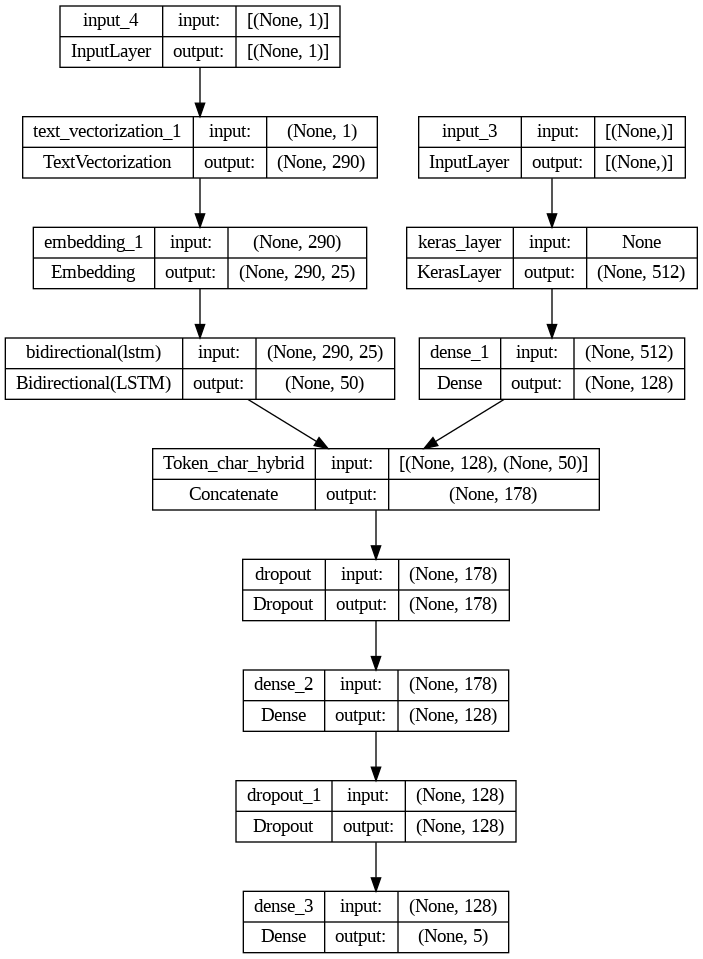

In [73]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=True,)

In [74]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_target_onehot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_target_onehot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_target_onehot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))

In [75]:
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [78]:
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['acc'])

In [80]:
history_4 = model_4.fit(train_char_token_dataset,epochs=3,
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
5627/5627 [==============================] - 248s 44ms/step - loss: 0.7894 - acc: 0.6952 - val_loss: 0.7219 - val_acc: 0.7261
Epoch 2/3
5627/5627 [==============================] - 259s 46ms/step - loss: 0.7659 - acc: 0.7058 - val_loss: 0.7026 - val_acc: 0.7320
Epoch 3/3
5627/5627 [==============================] - 310s 55ms/step - loss: 0.7470 - acc: 0.7140 - val_loss: 0.6850 - val_acc: 0.7417


In [81]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6914 - acc: 0.7388


[0.6913899183273315, 0.7387793064117432]

In [82]:
pred_4_probs = model_4.predict(val_char_token_dataset)
pred_4 = pred_4_probs.argmax(axis=1)

945/945 [==============================] - 22s 20ms/step


In [98]:
model_4_results = calculate_results(val_labels_enc , pred_4)
model_4_results

{'Accuracy': 0.7387792929961605,
 'Precision': 0.7353931288809079,
 'F1_score': 0.7343036633240125,
 'Recall': 0.7387792929961605}

### position embeddings 
we are create a model that takes token, char and positional embeddings to our model 

In [99]:
train_df

,line_no,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
...,...,...,...,...
180035,7,RESULTS,For the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"For PAV , a significantly greater percentage o...",11
180037,9,RESULTS,Both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11


<Axes: >

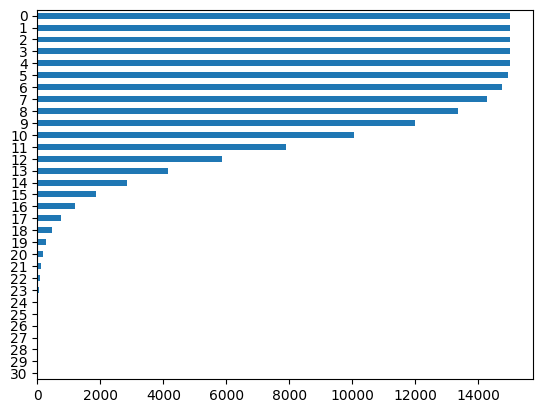

In [103]:
train_df.line_no.value_counts(ascending=True).plot(kind='barh')

<Axes: xlabel='line_no', ylabel='Count'>

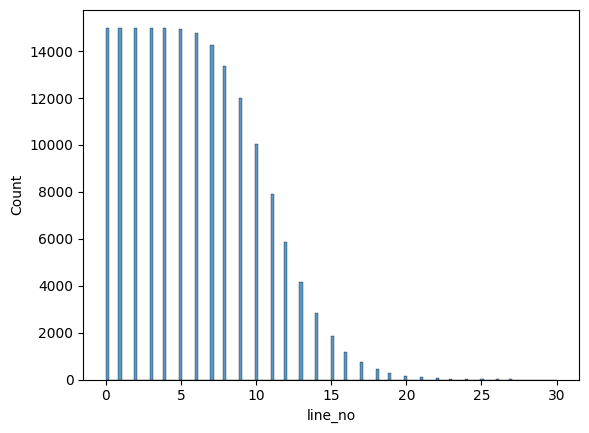

In [105]:
sns.histplot(train_df.line_no)

In [111]:
np.percentile(train_df.line_no.to_numpy(),98)

15.0

In [117]:
# onehot encode the line no column

train_line_onehot = tf.one_hot(train_df.line_no.to_numpy(), depth=15)
val_line_onehot = tf.one_hot(val_df.line_no.to_numpy(), depth=15)
test_line_onehot = tf.one_hot(test_df.line_no.to_numpy(), depth=15)

train_line_onehot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

<Axes: >

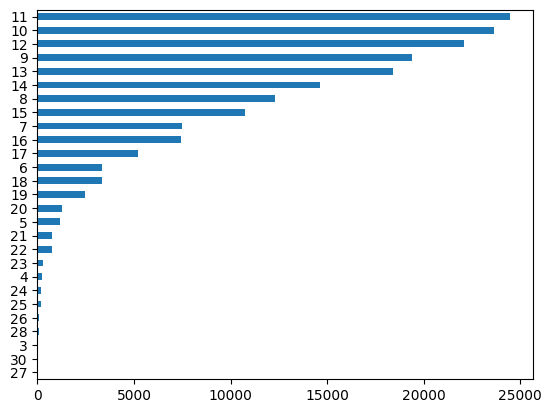

In [121]:
# next we are going to preprocess the total lines

train_df.total_lines.value_counts(ascending=True).plot(kind='barh')

<Axes: ylabel='Count'>

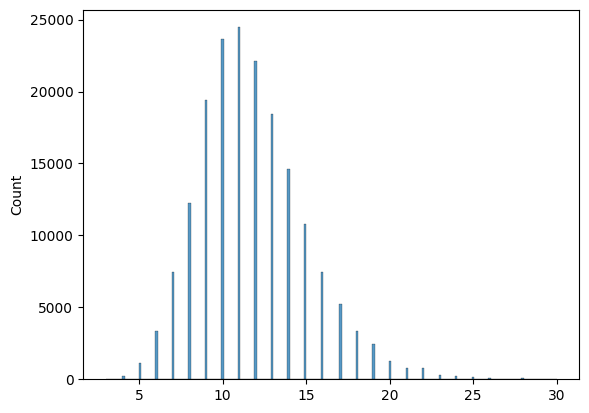

In [122]:
sns.histplot(train_df.total_lines.to_numpy())

In [124]:
np.percentile(train_df.total_lines.to_numpy(),98)

20.0

In [125]:
train_total_line_onehot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_line_onehot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_line_onehot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)

train_total_line_onehot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

## Model 5 (tribrid model)

In [136]:
#model1
token_inputs = layers.Input(shape=[],dtype=tf.string)
token_encoder = use_encoder(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_encoder)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

#model_2
char_inputs  = layers.Input(shape=(1,),dtype=tf.string)
char_vect = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vect)
char_layer_1 = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_layer_1)

#model-3
line_inputs = layers.Input(shape=(15,))
line_inputs_layer1 = layers.Dense(128,activation = 'relu')(line_inputs)
line_outputs = layers.Dense(64,activation='relu')(line_inputs_layer1)
line_model = tf.keras.Model(inputs=line_inputs,outputs=line_outputs)

#model-4
total_line_inputs = layers.Input(shape=(20,))
total_line_inputs_layer1 = layers.Dense(128,activation = 'relu')(total_line_inputs)
total_line_outputs = layers.Dense(64,activation='relu')(total_line_inputs_layer1)
total_line_model = tf.keras.Model(inputs=total_line_inputs,outputs=total_line_outputs)

#concatenate layer 1
token_char_concat1 = layers.Concatenate(name='Token_char_hybrid')([token_model.output,char_model.output])

#concatenate layer 2
token_char_concat2 = layers.Concatenate(name='total_line_hybrid')([token_char_concat1,line_model.output,
                                                                   total_line_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat2)
combined_dense_layer = layers.Dense(200,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense_layer)
final_output = layers.Dense(5,activation='softmax')(final_dropout)

#finally we can create model

model_5 = tf.keras.Model(inputs=[token_model.input,char_model.input,line_model.input,total_line_model.input],
                         outputs=final_output,
                         name='model_4_token_char_embeddings')

In [137]:
model_5.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_12[0][0]']               
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['inp

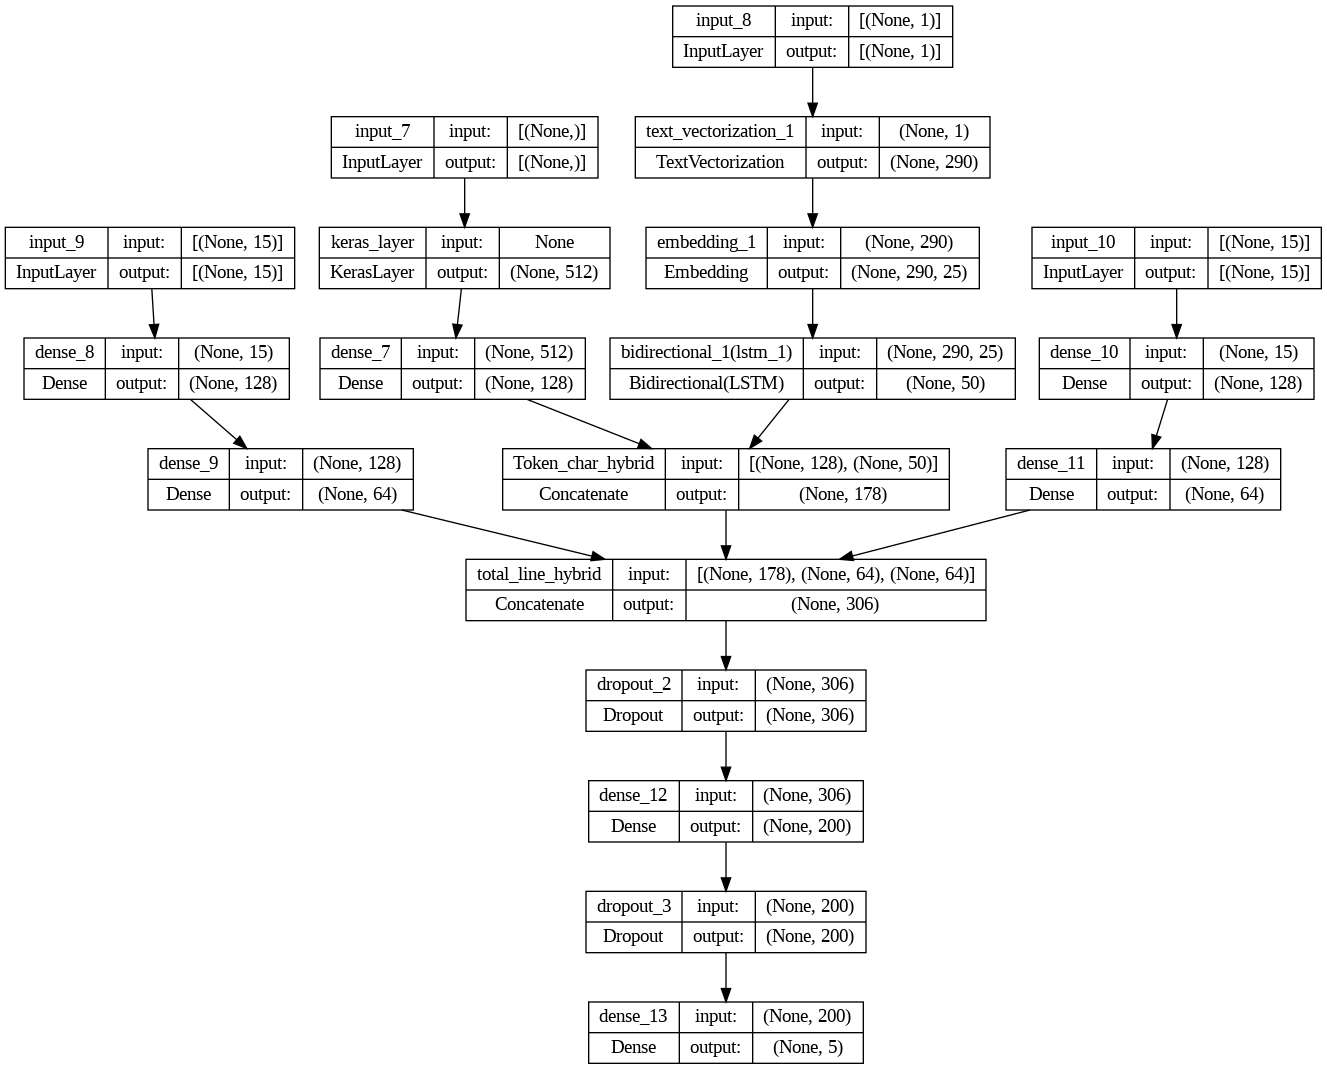

In [128]:
plot_model(model_5,show_shapes=True)

In [138]:
model_5.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['acc'])

In [132]:
# create dataset for all inputs
train_inputs_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_onehot,train_total_line_onehot))
train_outputs_labels = tf.data.Dataset.from_tensor_slices(train_target_onehot)
final_train_dataset = tf.data.Dataset.zip((train_inputs_data,train_outputs_labels))

val_inputs_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,val_line_onehot,val_total_line_onehot))
val_outputs_labels = tf.data.Dataset.from_tensor_slices(val_target_onehot)
final_val_dataset = tf.data.Dataset.zip((val_inputs_data,val_outputs_labels))

test_inputs_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars,test_line_onehot,test_total_line_onehot))
test_outputs_labels = tf.data.Dataset.from_tensor_slices(test_target_onehot)
final_test_dataset = tf.data.Dataset.zip((test_inputs_data,test_outputs_labels))

In [133]:
final_train_dataset = final_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_val_dataset = final_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
final_test_dataset = final_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [134]:
final_train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [139]:
history_5 = model_5.fit(final_train_dataset,epochs=5,
                        validation_data=final_val_dataset,
                        validation_steps=int(0.1*len(final_val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 281s 48ms/step - loss: 0.4868 - acc: 0.8117 - val_loss: 0.3747 - val_acc: 0.8564
Epoch 2/5
5627/5627 [==============================] - 270s 48ms/step - loss: 0.4116 - acc: 0.8438 - val_loss: 0.3483 - val_acc: 0.8690
Epoch 3/5
5627/5627 [==============================] - 338s 60ms/step - loss: 0.3930 - acc: 0.8514 - val_loss: 0.3494 - val_acc: 0.8657
Epoch 4/5
5627/5627 [==============================] - 273s 49ms/step - loss: 0.3814 - acc: 0.8559 - val_loss: 0.3426 - val_acc: 0.8690
Epoch 5/5
5627/5627 [==============================] - 286s 51ms/step - loss: 0.3738 - acc: 0.8592 - val_loss: 0.3397 - val_acc: 0.8684


In [140]:
model_5.evaluate(final_val_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.3322 - acc: 0.8725


[0.33224573731422424, 0.8725340962409973]

In [142]:
pred_5_probs = model_5.predict(final_val_dataset)
pred_5 = pred_5_probs.argmax(axis=1)

945/945 [==============================] - 22s 19ms/step


In [143]:
model_5_results = calculate_results(val_labels_enc,pred_5)
model_5_results

{'Accuracy': 0.8725340924136105,
 'Precision': 0.877473635792288,
 'F1_score': 0.8687114766630712,
 'Recall': 0.8725340924136105}

In [149]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,F1_score,Recall
baseline,0.728750,0.723371,0.710089,0.728750
custom_token_embed_conv1d,0.812161,0.821884,0.815050,0.812161
pretrained_token_embed,0.767543,0.765645,0.763087,0.767543
custom_char_embed_conv1d,0.727890,0.730524,0.725631,0.727890
hybrid_char_token_embed,0.738779,0.735393,0.734304,0.738779
tribrid_pos_char_token_embed,0.872534,0.877474,0.868711,0.872534


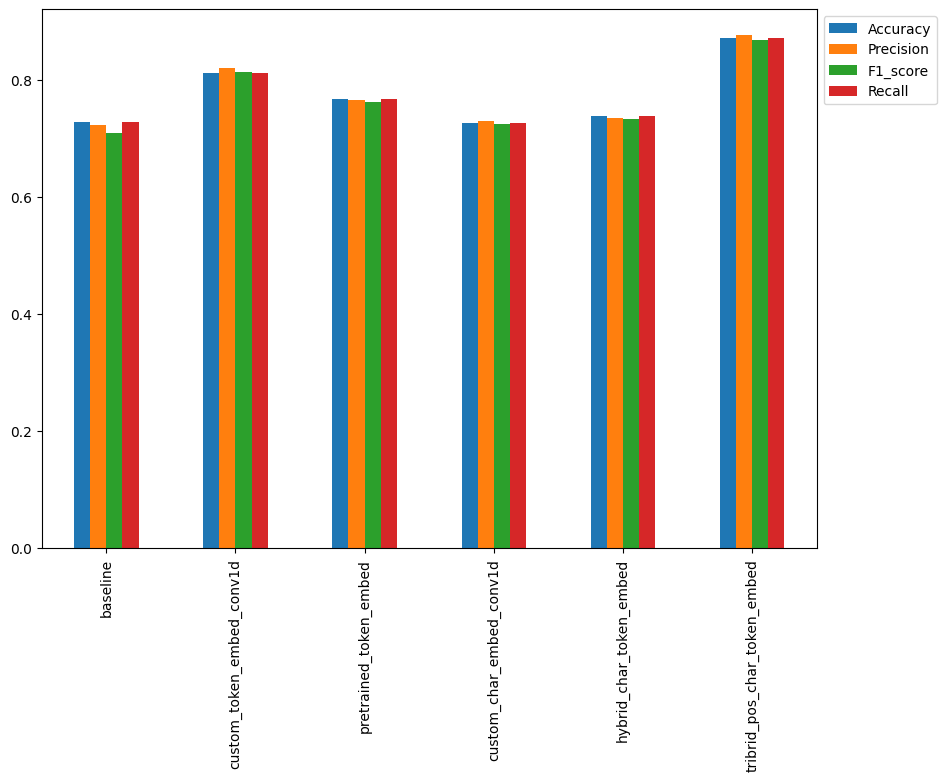

In [150]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [153]:
model_5.save('/content/drive/MyDrive/pubmed_model_5')